# Notebook to plot the helicity angles of $a_{0}$

In [1]:
import ROOT
import numpy as np
import my_library.common_analysis_tools as ct
import my_library.constants as constants
import my_library.kinematic_cuts as kcuts
import pandas as pd

Welcome to JupyROOT 6.24/04


In [2]:
def define_a0_helicity(channel, run_period, data_type, thrown=False, filtered=True):
    if data_type not in ['signal', 'data']:
        return None

    if thrown: filtered=False
    df = ct.get_dataframe(channel, run_period, data_type, thrown=thrown, filtered=filtered)

    if not thrown:
        proton = 'p'
        if channel == 'pipkmks':
            pion = 'pip1'
            kaon = 'km'
        else:
            pion = 'pim1'
            kaon = 'kp'
    else: 
        proton = 'Proton'
        if channel == 'pipkmks':
            pion = 'PiPlus1'
            kaon = 'KMinus'
            ks = 'PiPlus2_{0} + PiMinus_{0}'
        else:
            pion = 'PiMinus1'
            kaon = 'KPlus'
            ks = 'PiMinus2_{0} + PiPlus_{0}'
        df = df.Define('ks_px', ks.format('px'))
        df = df.Define('ks_py', ks.format('py'))
        df = df.Define('ks_pz', ks.format('pz'))
        df = df.Define('ks_E', ks.format('E'))
        df = df.Define('ks_m', 'sqrt(ks_E*ks_E - ks_px*ks_px - ks_py*ks_py - ks_pz*ks_pz)')

    df = df.Define('kk_px', f'{kaon}_px + ks_px')
    df = df.Define('kk_py', f'{kaon}_py + ks_py')
    df = df.Define('kk_pz', f'{kaon}_pz + ks_pz')
    df = df.Define('kk_E', f'{kaon}_E + ks_E')
    df = df.Define("beam_p4", "ROOT::Math::PxPyPzEVector(e_beam, 0, 0, e_beam)")
    df = df.Define("target_p4", "ROOT::Math::PxPyPzEVector(0, 0, 0, 0.938272)")
    df = df.Define('cm_boost_vector', '(beam_p4 + target_p4).BoostToCM()')
    df = df.Define('p_p4', f'ROOT::Math::PxPyPzEVector({proton}_px, {proton}_py, {proton}_pz, {proton}_E)')
    df = df.Define(f'{channel}_p4', f'ROOT::Math::PxPyPzEVector({channel}_px, {channel}_py, {channel}_pz, {channel}_E)')
    df = df.Define('kk_p4', 'ROOT::Math::PxPyPzEVector(kk_px, kk_py, kk_pz, kk_E)')
    df = df.Define(f'{pion}_p4', f'ROOT::Math::PxPyPzEVector({pion}_px, {pion}_py, {pion}_pz, {pion}_E)')
    df = df.Define('cm_boost', "ROOT::Math::Boost(cm_boost_vector)")
    df = df.Define('p_p4_cm', 'cm_boost(p_p4)')
    df = df.Define(f'{channel}_p4_cm', f'cm_boost({channel}_p4)')
    df = df.Define('kk_p4_cm', 'cm_boost(kk_p4)')
    df = df.Define(f'{pion}_p4_cm', f'cm_boost({pion}_p4)')
    df = df.Define('beam_p4_cm', 'cm_boost(beam_p4)')
    df = df.Define('target_p4_cm', 'cm_boost(target_p4)')
    df = df.Define('f1_rest_boost_vector', f'{channel}_p4_cm.BoostToCM()')
    df = df.Define('f1_rest_boost', 'ROOT::Math::Boost(f1_rest_boost_vector)')
    df = df.Define('kk_p4_rest', 'f1_rest_boost(kk_p4_cm)')
    df = df.Define(f'{pion}_p4_rest', f'f1_rest_boost({pion}_p4_cm)')
    df = df.Define('yhat', f'beam_p4_cm.Vect().Cross({channel}_p4_cm.Vect()).Unit()')
    df = df.Define('zhat', f'{channel}_p4_cm.Vect().Unit()')
    df = df.Define('xhat', 'yhat.Cross(zhat)')
    df = df.Define('kk_rest_p3', 'kk_p4_rest.Vect()')
    df = df.Define('kk_helicty_p3', 'ROOT::Math::XYZVector(kk_rest_p3.Dot(xhat), kk_rest_p3.Dot(yhat), kk_rest_p3.Dot(zhat))')
    df = df.Define('kk_helicity_costheta', 'kk_helicty_p3.Z()/sqrt(kk_helicty_p3.Mag2())')

    return df

In [3]:
ROOT.EnableImplicitMT()
ROOT.gStyle.SetOptStat(0)

In [4]:
channel = 'pipkmks'
# channel = 'pimkpks'
run_period = '2017'

if channel == 'pipkmks':
    cut = kcuts.KSTAR_ALL_CUT_PIPKMKS
elif channel == 'pimkpks':
    cut = kcuts.KSTAR_ALL_CUT_PIMKPKS

In [5]:
df_data = define_a0_helicity(channel, run_period, 'data').Filter(cut)
df_signal = define_a0_helicity(channel, run_period, 'signal').Filter(cut)
df_thrown = define_a0_helicity(channel, run_period, 'signal', thrown=True)

In [6]:
hist_1285_kk_data = df_data.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('1285_kk_costheta_data', '1285_kk_costheta_data', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_1285_kk_signal = df_signal.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('1285_kk_costheta_signal', '1285_kk_costheta_signal', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_1285_kk_thrown = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('1285_kk_costheta_thrown', '1285_kk_costheta_thrown', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()

In [7]:
hist_1285_kk_data.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
hist_1285_kk_signal.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
hist_1285_kk_thrown.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['purple']))

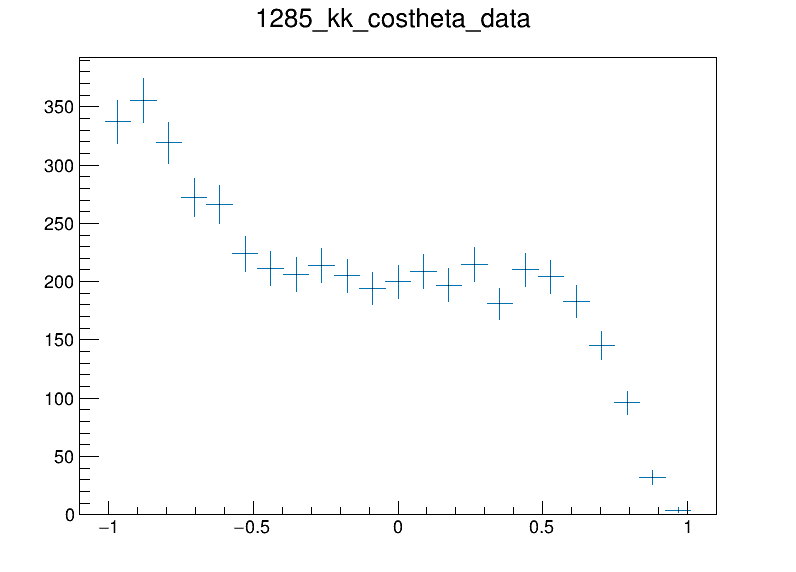

In [8]:
c1 = ROOT.TCanvas('c1', 'c1', 800, 600)
# hist_1285_kk_thrown.Draw('E')
# hist_1285_kk_signal.Draw('E SAME')
hist_1285_kk_data.Draw('E')
c1.Draw()

In [9]:
hist_1285_kk_data.Sumw2()
hist_1285_kk_signal.Sumw2()
hist_1285_kk_thrown.Sumw2()

acceptance = hist_1285_kk_signal.Clone('acceptance')
acceptance.Divide(hist_1285_kk_thrown)

for i in range(2, hist_1285_kk_data.GetNbinsX()):
    print(f'data: {hist_1285_kk_data.GetBinContent(i)} || efficiency: {acceptance.GetBinContent(i)} || efficiency corrected: {hist_1285_kk_data.GetBinContent(i)/acceptance.GetBinContent(i)}')

hist_1285_kk_data.Divide(acceptance)


data: 337.0 || efficiency: 0.020564970834719257 || efficiency corrected: 16387.088642550003
data: 355.0 || efficiency: 0.020951830015397053 || efficiency corrected: 16943.62734611335
data: 319.0 || efficiency: 0.02122542934973232 || efficiency corrected: 15029.142390659013
data: 272.0 || efficiency: 0.021722023844913632 || efficiency corrected: 12521.853485751088
data: 266.0 || efficiency: 0.022104970297887928 || efficiency corrected: 12033.492758206312
data: 224.0 || efficiency: 0.022665565239633763 || efficiency corrected: 9882.833171453678
data: 211.0 || efficiency: 0.023198936245601872 || efficiency corrected: 9095.244616657888
data: 206.0 || efficiency: 0.023914951653232153 || efficiency corrected: 8613.85809961103
data: 214.0 || efficiency: 0.024524755830791507 || efficiency corrected: 8725.87688442211
data: 205.0 || efficiency: 0.02497269606186607 || efficiency corrected: 8208.965483428123
data: 194.0 || efficiency: 0.02525985448918467 || efficiency corrected: 7680.170924304555


True

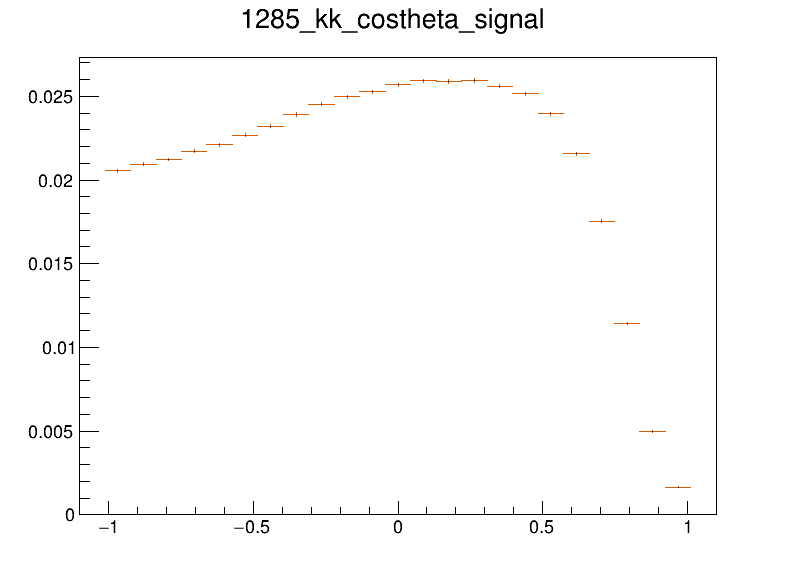

In [10]:
acceptance.Draw('E')
c1.Draw()

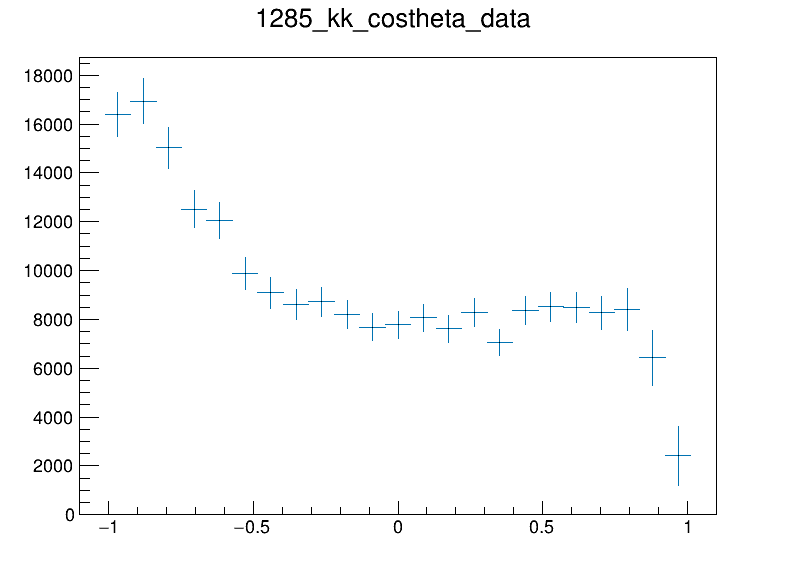

In [11]:
hist_1285_kk_data.Draw("E")
c1.Draw()

In [12]:
func_eta = ROOT.TF1("func_eta", "[0]", -1, 1)
func_f1 = ROOT.TF1("func_f1", "[0]*cos(x)*cos(x) + [1]*sin(x)*sin(x)", -1, 1)

func_eta.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
func_f1.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))


func_eta.SetParameter(0, 600)
func_f1.SetParameter(0, -600)
func_f1.SetParameter(1, 200)

In [13]:
hist_1285_kk_data.Fit(func_eta, "BS+")
hist_1285_kk_data.Fit(func_f1, "BS+")

 FCN=313.134 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=5.05329e-16    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.97088e+03   1.36046e+02   1.17675e+00   2.33678e-10
 FCN=218.26 FROM MIGRAD    STATUS=CONVERGED      28 CALLS          29 TOTAL
                     EDM=1.93623e-22    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.60798e+03   1.95159e+02   1.19153e+00   1.19266e-13
   2  p1           1.45098e+04   5.84711e+02   3.55830e+00   1.99686e-14


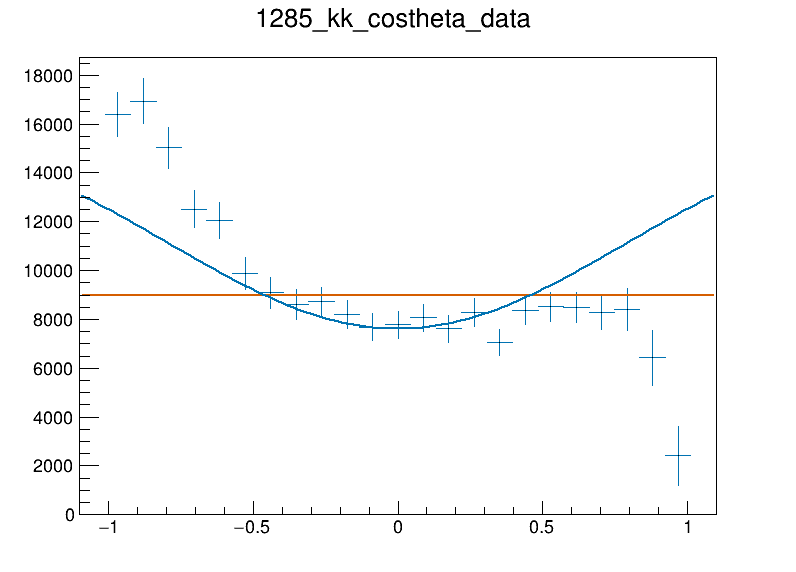

In [14]:
hist_1285_kk_data.Draw("E")
c1.Draw()

In [15]:
hist2d = df_data.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

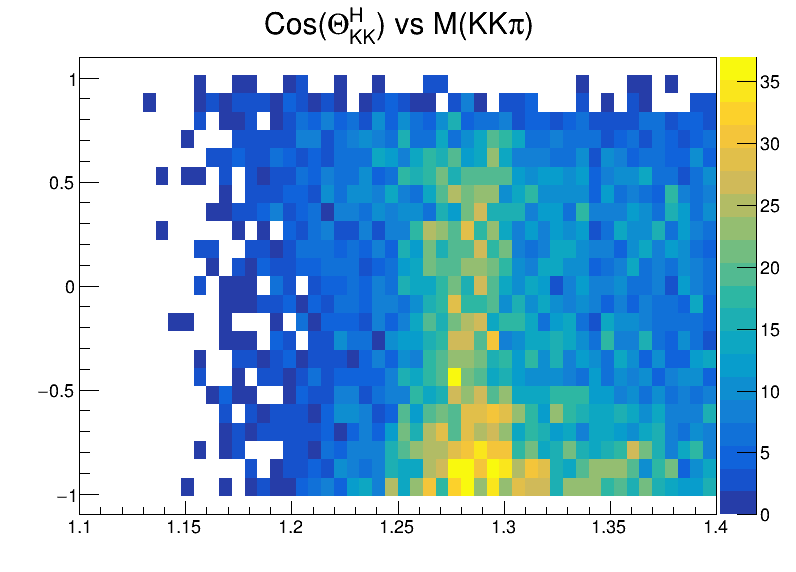

In [16]:
hist2d.Draw('COLZ')
c1.Draw()

In [17]:
hist_signal_costhets = df_signal.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_signal_kkpi = df_signal.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m').GetValue()
hist_signal_2d = df_signal.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

In [22]:
hist_thrown_costhets = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_thrown_kkpi = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m').GetValue()
hist_thrown_2d = df_thrown.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


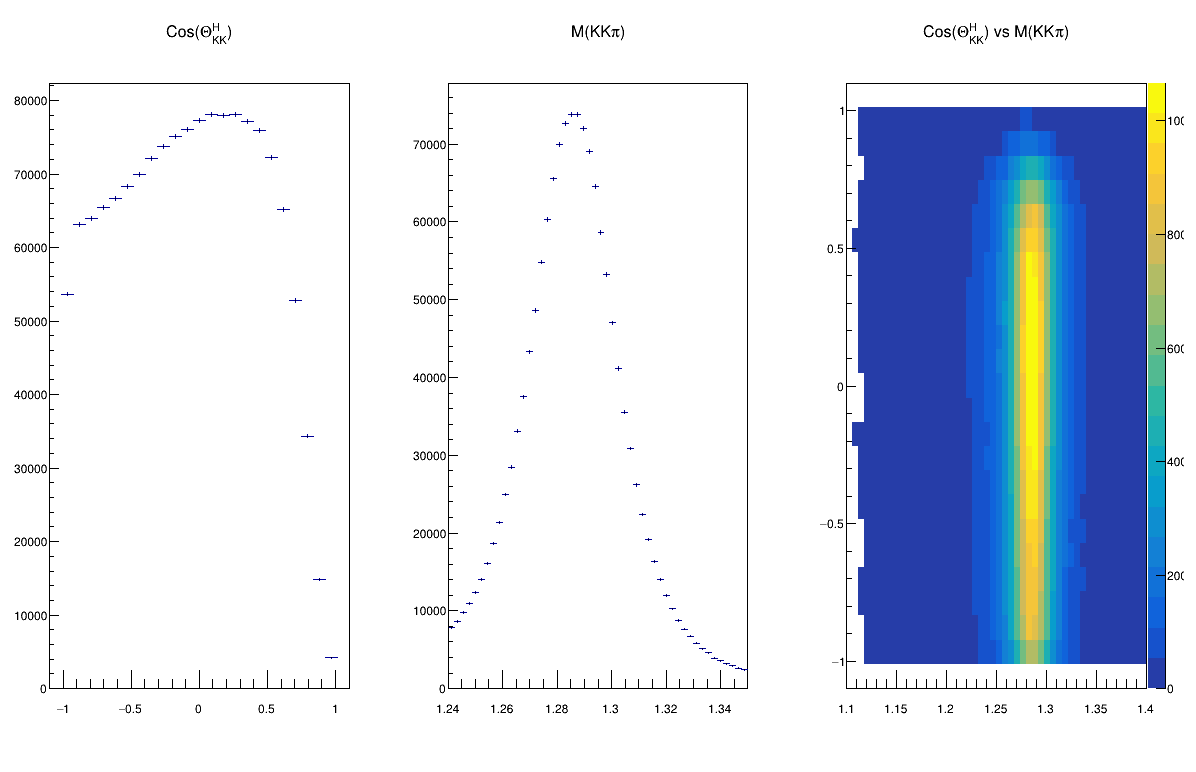

In [23]:
c2 = ROOT.TCanvas('c2', 'c2', 1200, 800)
c2.Divide(3, 1)

c2.cd(1)
hist_signal_costhets.Draw('E')
c2.cd(2)
hist_signal_kkpi.Draw('E')
c2.cd(3)
hist_signal_2d.Draw('COLZ')
c2.Draw()

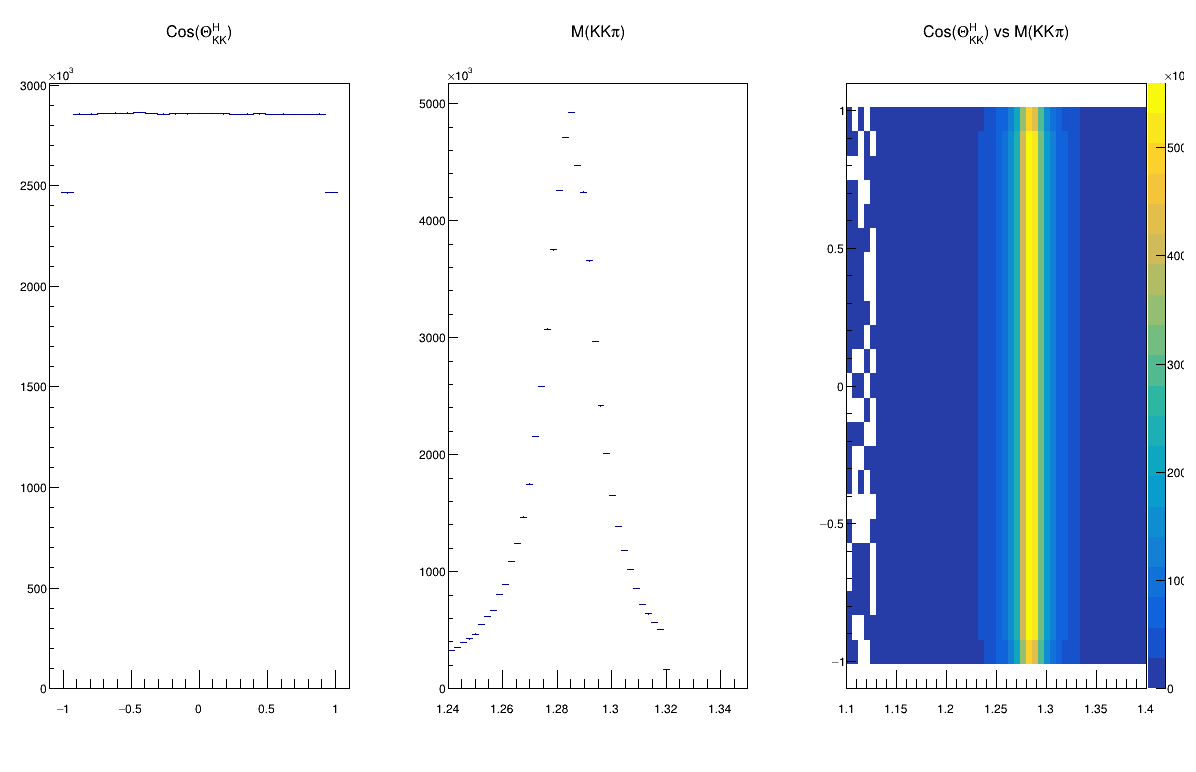

In [24]:
c2.cd(1)
hist_thrown_costhets.Draw('E')
c2.cd(2)
hist_thrown_kkpi.Draw('E')
c2.cd(3)
hist_thrown_2d.Draw('COLZ')
c2.Draw()

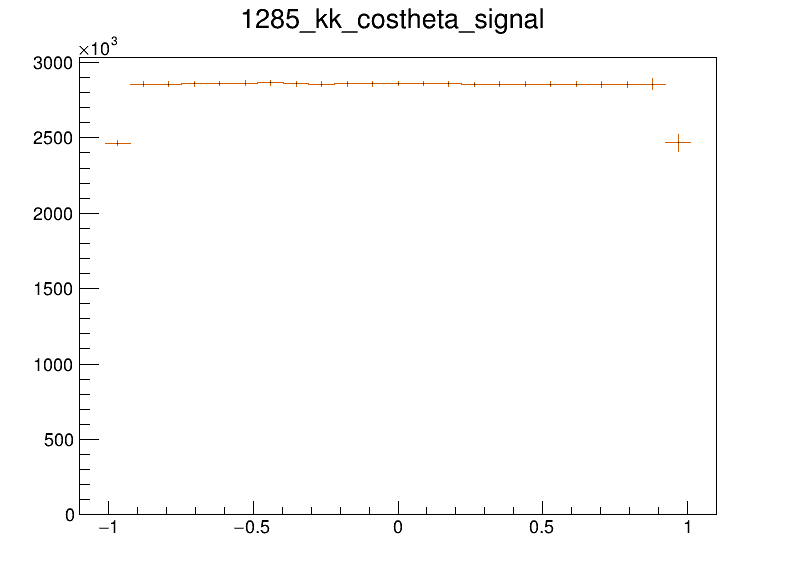

In [25]:
c1.cd()
hist_eff_test = hist_1285_kk_signal.Clone('eff_test')
hist_eff_test.Divide(acceptance)

hist_eff_test.Draw('E')
c1.Draw()